## Creating Toy Data

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate correlation between insolation and toy data, in order to illustrate the difficulty in distinguishing between seasonal and physical lag when conducting this analysis.

The notebook is structured as follows:

1. Define a function that will be used to calculate correlations between records that contain large hiatuses
2. Create sinusoidal toy data
3. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
4. Calculate correlation between shifted insolation and toy data
5. Define further seasonal insolation curves using climlab
6. Calculate correlation between seasonal insolation and toy data
7. Plot results

In [1]:
# Importing relevant packages

import math

from tqdm import tqdm

import pyleoclim as pyleo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

Here we create our `correlate_hiatus_series` function. This function essentially removes the hiatuses from one series (in this case, `series1`), aligns the remaining time axis with `series2`, and calculates the [correlation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.correlation) between these records. 

*Note that this function makes the interpretation of significance very difficult.* None of the usual measures of significance apply here, as we're destroying much of the temporal information in `series1` by removing the hiatuses and placing the series on a dummy time axis for correlation purposes. In this case, since we're using continuous toy data, this isn't too important, but it will matter later on!

In [ ]:
def correlate_hiatus_series(series1, series2, cutoff_scale1=None):
    """Function to correlate series with large gaps. This is done by segmenting the time series, smoothing (if this is desired),
    and then reconnecting the time series with a dummy time axis so as not to re-introduce the hiatuses.

    series1 : pyleoclim.Series
        One series to correlate, presumed to have hiatuses
    series2 : pyleoclim.Series
        Other series to correlate, presumed to not have hiatuses
    cutoff_scale : int
        Cutoff scale for smoothing for series 1
    """

    if cutoff_scale1:
        segments = series1.segment()
        if isinstance(segments, pyleo.core.multiplegeoseries.MultipleGeoSeries):
            smoothed_series_value = []
            smoothed_series_time = []
            for segment in segments.series_list:
                if max(segment.time) - min(segment.time) > 6:
                    segment_smooth = segment.interp().filter(cutoff_scale=cutoff_scale1)
                    smoothed_series_value.extend(segment_smooth.value)
                    smoothed_series_time.extend(segment_smooth.time)
            smoothed_series = series1.copy()
            smoothed_series.value = smoothed_series_value
            smoothed_series.time = smoothed_series_time
        else:
            smoothed_series = series1.interp().filter(cutoff_scale=cutoff_scale1)
        series1 = smoothed_series

    smoothed_segments = series1.segment()
    series1_values = []
    series2_values = []
    if isinstance(smoothed_segments, pyleo.core.multiplegeoseries.MultipleGeoSeries):
        for segment in smoothed_segments.series_list:
            ms = pyleo.MultipleSeries([segment, series2]).common_time()
            s1, s2 = ms.series_list
            series1_values.extend(s1.value)
            series2_values.extend(s2.value)
        assert len(series1_values) == len(series2_values)
        time = np.arange(len(series1_values))
        s1_corr = pyleo.Series(time=time, value=series1_values, verbose=False)
        s2_corr = pyleo.Series(time=time, value=series2_values, verbose=False)
    else:
        s1_corr = series1
        s2_corr = series2

    corr = s1_corr.correlation(s2_corr, number=1, mute_pbar=True)

    return corr

We create some simple, sinusoidal toy data using numpy and a dummy [GeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#geoseries-pyleoclim-geoseries) object:

In [ ]:
# Creating toy data

toy_time = np.arange(0, 200, 1)
toy_value = np.sin(2 * np.pi * toy_time / 19) + np.sin(2 * np.pi * toy_time / 23)
toy_series = pyleo.GeoSeries(
    time=toy_time,
    value=toy_value,
    time_name="Age",
    time_unit="Kyr BP",
    label="Toy Series",
    value_unit="unitless",
    verbose=False,
    lat=10,
    lon=10,
)

### Calculating correlations between toy data and shifted insolation curves

Here we first create insolation curves for integrated July insolation at latitudes from the equator up to 80N:

In [ ]:
# Creating our insolation object

lat_list = np.arange(0, 85, 5)

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

# Day numbers from June 1st to August 31st
july_days = np.arange(182, 213)

july_dict = {}

for lat in lat_list:
    inso = daily_insolation(lat=lat, day=july_days, orb=orb).mean(dim="day")
    inso_series = pyleo.Series(
        time=0 - years[::-1],
        value=inso[::-1],
        time_name="Age",
        time_unit="Kyr BP",
        value_name=f"july Insolation {lat}",
        value_unit="W/m^2",
        verbose=False,
    )
    july_dict[lat] = inso_series

Now we calculate the correlation between our toy data and shifted versions of our insolation curves at each latitude:

In [ ]:
# Calculating the correlation between shifted versions of our insolation object and our toy data

shift_array = np.arange(
    -3.5, 3.6, 1.75
)  # Define the leads/lags to be analyzed in units of your time axis (we use kyrs BP here)
# shift_array = np.arange(-8,8.1,2)
series_shift_dict = {shift: {} for shift in shift_array}
shifted_series_dict = {lat: {} for lat in lat_list}

for shift in tqdm(shift_array):
    corr_res = {}
    for corr_lat, corr_series in july_dict.items():
        series = toy_series.copy()
        shift_corr_series = corr_series.copy()
        shift_corr_series.time += shift
        shifted_series_dict[corr_lat][shift] = shift_corr_series
        # corr = correlate_hiatus_series(series1=series,series2=shift_corr_series,cutoff_scale1=6)
        corr = series.correlation(shift_corr_series, number=1, mute_pbar=True)
        corr_res[corr_lat] = [corr.p, corr.r]

    correlated_inso = []

    for corr_lat, res in corr_res.items():
        corr_p, corr_r = res
        correlated_inso.append([corr_lat, corr_p, corr_r])

    series_shift_dict[shift] = correlated_inso

100%|██████████| 5/5 [00:00<00:00, 45.71it/s]


The correlation `r` values are then placed into a pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) for easier plotting:

In [ ]:
# Putting the results into a dataframe

columns = [math.ceil(a) for a in shift_array * 1000]
shift_df_r = pd.DataFrame(index=np.arange(5, 81, 5), columns=columns)
for shift in shift_array:
    corr_list = series_shift_dict[shift]
    for corr in corr_list:
        lat = np.abs(corr[0])
        r = corr[2]
        shift_df_r.loc[lat, math.ceil(shift * 1000)] = r

The same is done for `r^2` values as well:

In [ ]:
# Putting the squared results into a dataframe

columns = [math.ceil(a) for a in shift_array * 1000]
shift_df_r2 = pd.DataFrame(index=np.arange(5, 81, 5), columns=columns)
for shift in shift_array:
    corr_list = series_shift_dict[shift]
    for corr in corr_list:
        lat = np.abs(corr[0])
        r = corr[2]
        shift_df_r2.loc[lat, math.ceil(shift * 1000)] = r**2

### Calculating correlations using different months of insolation instead of different shifts

Now, instead of calculating correlation between our toy data and shifted insolation, we calculate correlation between toy data and insolation at different months. First we create our insolation dictionary containing insolation at multiple latitudes, integrated over individual summer months:

In [ ]:
# Creating our insolation objects

inso_dict = {}
month_dict = {
    # 'January' : np.arange(1,32),
    # 'February' : np.arange(32,60),
    # 'March' : np.arange(60,91),
    # 'April' : np.arange(91,121),
    "May": np.arange(121, 152),
    "June": np.arange(152, 182),
    "July": np.arange(182, 213),
    "August": np.arange(213, 244),
    "September": np.arange(244, 274),
    # 'October' : np.arange(274,304),
    # 'November' : np.arange(304,335),
    # 'December': np.arange(335,365)
}  # Key is month number, value is day numbers associated with that month

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

for month, days in month_dict.items():
    inso_dict[month] = {}
    for lat in lat_list:
        days = month_dict[month]
        inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim="day")
        inso_series = pyleo.Series(
            time=years,
            value=inso,
            time_name="Time",
            time_unit="Kyr AD",
            value_name=f"{month} Insolation {lat}",
            value_unit="W/m^2",
            verbose=False,
        )
        inso_dict[month][lat] = inso_series.convert_time_unit("Kyr BP")

Calculating correlation, same as before:

In [ ]:
# Calculating the correlation between different months of insolation and our toy data

series_month_dict = {month: {} for month in inso_dict.keys()}

for month in tqdm(series_month_dict.keys()):
    series = toy_series.copy()
    month_lat_dict = inso_dict[month]
    corr_res = {}
    for corr_lat, corr_series in month_lat_dict.items():
        corr = correlate_hiatus_series(
            series1=series, series2=corr_series, cutoff_scale1=6
        )
        corr_res[corr_lat] = [corr.p, corr.r]

    correlated_inso = []

    for corr_lat, res in corr_res.items():
        corr_p, corr_r = res
        correlated_inso.append([corr_lat, corr_p, corr_r])

    series_month_dict[month] = correlated_inso

100%|██████████| 5/5 [00:00<00:00, 25.49it/s]


Putting the results into DataFrames:

In [ ]:
# Putting the results into a dataframe

columns = list(series_month_dict.keys())
month_df_r = pd.DataFrame(index=np.arange(5, 81, 5), columns=columns)
for month in series_month_dict.keys():
    corr_list = series_month_dict[month]
    for corr in corr_list:
        lat = np.abs(corr[0])
        r = corr[2]
        month_df_r.loc[lat, month] = r

In [ ]:
# Putting the squared results into a dataframe

columns = list(series_month_dict.keys())
month_df_r2 = pd.DataFrame(index=np.arange(5, 81, 5), columns=columns)
for month in series_month_dict.keys():
    corr_list = series_month_dict[month]
    for corr in corr_list:
        lat = np.abs(corr[0])
        r = corr[2]
        month_df_r2.loc[lat, month] = r**2

### Creating the multi-panel figure

Now, we put everything together and create a multi-panel figure:

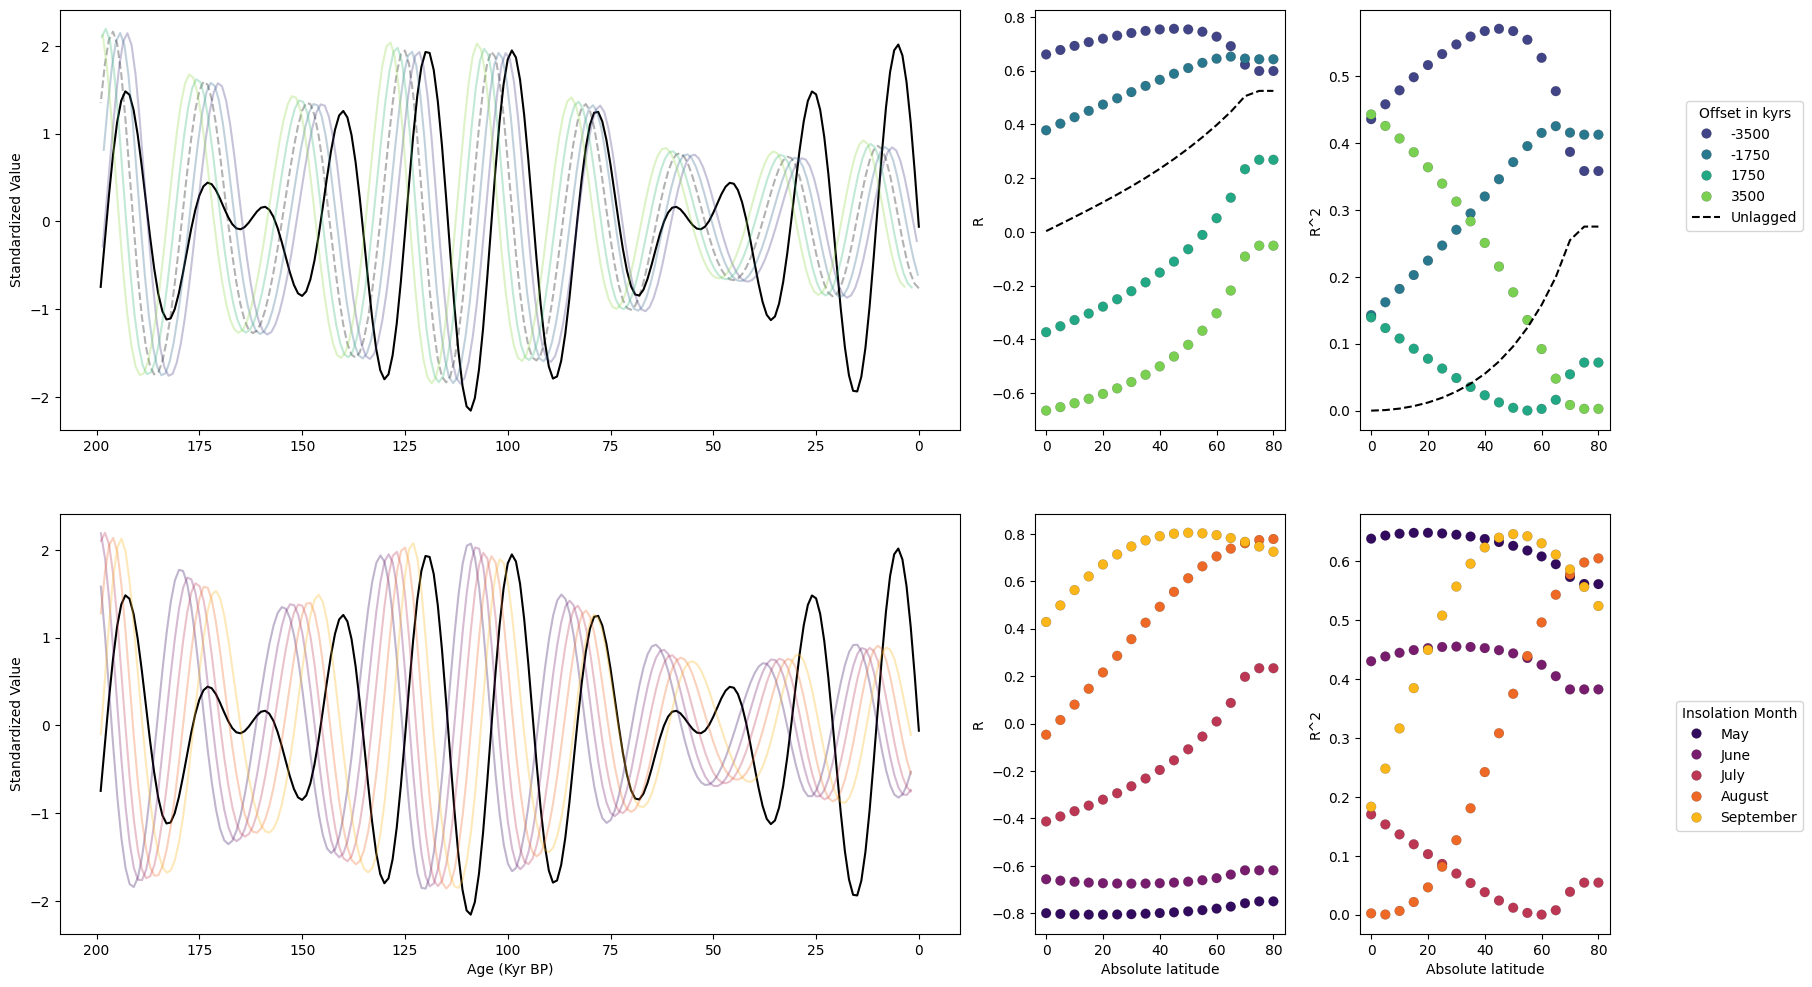

In [ ]:
# Create a figure
fig = plt.figure(figsize=(20, 12))

# Create a GridSpec object with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 5, wspace=0.3)

# Add subplots using the GridSpec object
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[0, 4])
ax4 = fig.add_subplot(gs[1, :3])
ax5 = fig.add_subplot(gs[1, 3])
ax6 = fig.add_subplot(gs[1, 4])

# Shift timeseries
shift_colors = sns.color_palette(
    "viridis", n_colors=len(shifted_series_dict[10].keys())
)

toy_series.standardize().plot(ax=ax1, color="black", label="Toy Series")
for idx, pair in enumerate(shifted_series_dict[10].items()):
    shift, shifted_series = pair
    if shift == 0:
        shifted_series.slice((min(toy_time), max(toy_time))).standardize().plot(
            ax=ax1, label=f"{shift}", alpha=0.3, color="black", linestyle="dashed"
        )
    else:
        shifted_series.slice((min(toy_time), max(toy_time))).standardize().plot(
            ax=ax1, label=f"{shift}", alpha=0.3, color=shift_colors[idx]
        )

ax1.set_ylabel("Standardized Value")
ax1.set_xlabel("")
ax1.legend().set_visible(False)
ax1.invert_xaxis()

# Shift r plot

shift_df_r_scatter = shift_df_r.drop(labels=0, axis=1)
sns.scatterplot(
    shift_df_r_scatter,
    ax=ax2,
    legend=True,
    palette="viridis",
    markers=["o" for _ in shift_df_r_scatter.columns],
    s=50,
    edgecolor="black",
    linewidth=0.1,
)
sns.lineplot(
    x=shift_df_r[0].index.to_numpy(),
    y=shift_df_r[0].to_numpy(),
    ax=ax2,
    linestyle="--",
    color="black",
    label="Unlagged",
)

ax2.set_ylabel("R")
# ax2.set_xlabel('Absolute latitude')

ax2.get_legend().remove()
# ax2.set_title(f"R vs. Latitude for {label.split('.')[0]}")

# Shift r^2 plot

shift_df_r2_scatter = shift_df_r2.drop(labels=0, axis=1)
sns.scatterplot(
    shift_df_r2_scatter,
    ax=ax3,
    legend=True,
    palette="viridis",
    markers=["o" for _ in shift_df_r_scatter.columns],
    s=50,
    edgecolor="black",
    linewidth=0.1,
)
sns.lineplot(
    x=shift_df_r2[0].index.to_numpy(),
    y=shift_df_r2[0].to_numpy(),
    ax=ax3,
    linestyle="--",
    color="black",
    label="Unlagged",
)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center right",
    bbox_to_anchor=[1, 0.75],
    title="Offset in kyrs",
)

ax3.set_ylabel("R^2")
# ax3.set_xlabel('Absolute latitude')

ax3.get_legend().remove()
# ax3.set_title(f"R^2 vs. Latitude for {label.split('.')[0]}")

# Month timeseries

month_colors = sns.color_palette("inferno", n_colors=len(month_dict.keys()))

toy_series.standardize().plot(ax=ax4, color="black", label="Toy Series")
for idx, month in enumerate(month_dict.keys()):
    inso_dict[month][10].slice((min(toy_time), max(toy_time))).standardize().plot(
        ax=ax4, label=f"{month}", alpha=0.3, color=month_colors[idx]
    )

ax4.set_ylabel("Standardized Value")
ax4.set_xlabel("Age (Kyr BP)")
ax4.invert_xaxis()

# Month r plot
sns.scatterplot(
    month_df_r,
    ax=ax5,
    legend=True,
    palette="inferno",
    markers=["o" for _ in month_df_r.columns],
    s=50,
    edgecolor="black",
    linewidth=0.1,
)

ax5.set_ylabel("R")
ax5.set_xlabel("Absolute latitude")

ax5.get_legend().remove()
# ax5.set_title(f"R vs. Latitude for {label.split('.')[0]}")

# Month r^2 plot

sns.scatterplot(
    month_df_r2,
    ax=ax6,
    legend=True,
    palette="inferno",
    markers=["o" for _ in month_df_r2.columns],
    s=50,
    edgecolor="black",
    linewidth=0.1,
)

handles, labels = ax6.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center right",
    bbox_to_anchor=[1, 0.25],
    title="Insolation Month",
)

ax6.set_ylabel("R^2")
ax6.set_xlabel("Absolute latitude")

ax6.get_legend().remove()
# ax6.set_title(f"R^2 vs. Latitude for {label.split('.')[0]}")